In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from tracking_test import testEnv

from algorithms.PPO import *


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'testEnv'
env = testEnv(dof=dof, dt=dt)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

# state_check=[] # 查看输入
## todo 打开这里的函数
# def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
return_list = []
# global state_check
# for i in range(1):  # 10
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        state = env.reset(train=True)
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action = agent.take_action(state, action_bound=action_bound, explore=True)
            next_state, reward, done, reward_plus = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward + reward_plus)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
        # episode_return = np.clip(episode_return, -1000, 1000)  # 不这样都没法看
        return_list.append(episode_return)
        agent.update(transition_dict, action_bound)
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)


Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]d:\3_Machine_Learning_in_Python\project03_fire_and_dodge_missile\algorithms\PPO.py:116: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration: 100%|██████████| 1000/1000 [01:09<00:00, 14.38it/s, episode=1000, return=345.729]


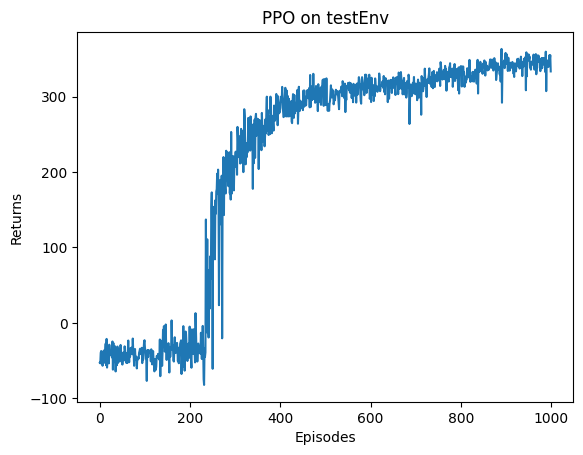

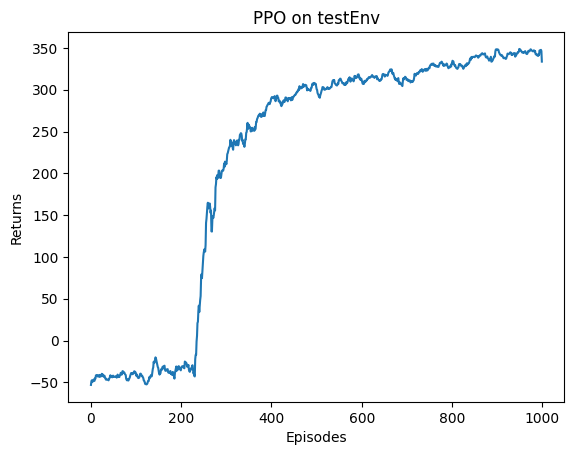

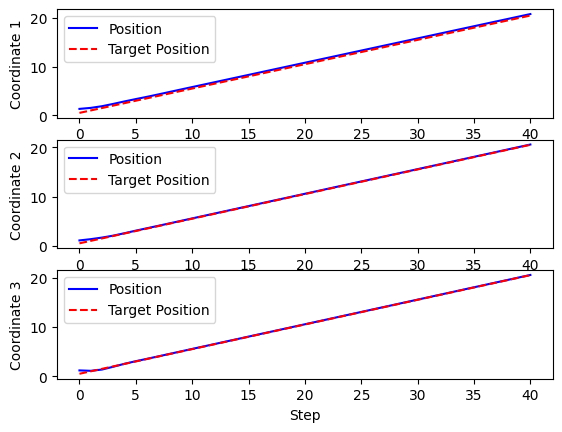

In [6]:

%matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))

mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))

car_trajectory = []
target_trajectory = []

episode_return = 0
state = env.reset(train=False)
done = False
while not done:  # 测试回合
    action = agent.take_action(state, action_bound=action_bound, explore=False)
    next_state, reward, done, reward_plus = env.step(action)
    car_trajectory.append(env.state[0:dof].copy())
    target_trajectory.append(env.target_pos_[0:dof].copy())
    state = next_state
    episode_return += reward


# 新增代码：绘制每个坐标分量的轨迹和目标值
plt.figure(4)
for i in range(dof):
    plt.subplot(dof, 1, i + 1)
    # 提取每个坐标分量的轨迹
    pos_trajectory = [state[i] for state in car_trajectory]
    # 假设 target_pos_ 是一个数组，每个元素对应一个时间步的目标位置
    target_pos_trajectory = [state[i] for state in target_trajectory]
    plt.plot(range(len(pos_trajectory)), pos_trajectory, 'b-', label='Position')
    plt.plot(range(len(target_pos_trajectory)), target_pos_trajectory, 'r--', label='Target Position')
    plt.xlabel('Step')
    plt.ylabel(f'Coordinate {i + 1}')
    plt.legend()

# # 显示所有图形
plt.show()

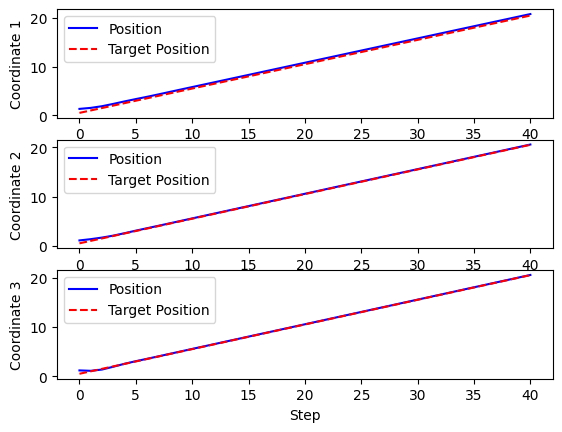